### 热最优路径法：
### 通过引入两个时间序列之间的距离矩阵，将传统的经济问题转化为统计物理学中的概率传递模型，利用分配函数的递归运算，最终可以得到两序列之间动态的领先滞后关系。

In [1]:
from jqdatasdk import *
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA 
import statsmodels.tsa.stattools as st
import warnings
warnings.filterwarnings('ignore')

from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

### 上证综指----情绪指标

In [2]:
data = pd.read_excel('C:Desktop/sent_index(1).xls',index_col=0)
data2 = pd.read_excel("C:Desktop/上证指数.xls",index_col=0)

In [3]:
data2['SCI'] = data2['收盘价'] 
data2['收盘价'] = data2['收盘价'].pct_change()

In [4]:
data = pd.concat((data,data2), axis=1)

In [6]:
ret0 = data3['收盘价'].pct_change()
# ret1 =  data3['sentiment'].pct_change()
data3['收盘价'] = ret0
# data3['sentiment'] = ret1
data3.dropna(inplace=True)

In [5]:
data3 = data

### 归一化处理

In [6]:
def scaler(df):
    return (df - np.mean(df)) / np.std(df)

In [7]:
X = data3['sentiment'].values
Y = data3['收盘价'].values
X = scaler(X)
Y = scaler(Y)

### 生成距离矩阵M

In [8]:
def D_matrix(X,Y):
    N = len(X)
    M = np.zeros((N,N))
    for t1 in range(N):
        for t2 in range(N):
            M[t1,t2] = np.abs(X[t1]-Y[t2])
    return M
def function(M,T):
    N = len(X)
    dim = len(M)
    G1= np.zeros((dim,dim))
    G1[0,:] = .1
    G1[:,0] = .1
    #G[:,0] = 1
    #G[0,:]
    for t1 in range(dim-1):
        for t2 in range(dim-1):
            G1[t1+1,t2+1] = (G1[t1+1,t2] + G1[t1, t2+1] + G1[t1, t2]) * np.exp(-M[t1+1,t2+1] / T)
            
    G2= np.zeros((dim,dim))
    G2[-1,:] = .1
    G2[:,-1] = .1    
    for t1 in range(dim-1)[::-1]:
        for t2 in range(dim-1)[::-1]:
            G2[t1,t2] = (G2[t1+1,t2] + G2[t1, t2+1] + G2[t1+1, t2+1]) * np.exp(-M[t1,t2] / T)
            
            
    G10 = np.zeros((2*N-1, 2*N-1))
    G20 = np.zeros((2*N-1, 2*N-1))
    for t1 in range(1,N):
        for t2 in range(1,N):
            t = t1 + t2 -2
            x = t2 - t1 + N-1
            G10[x,t] = G1[t1,t2]
            G20[x,t] = G2[t1,t2]

    X_t1 = np.zeros((2*N-1))
    X_t2 = np.zeros((2*N-1))
    
    for t in range(2*N-1):
        index1 = np.where(G10[:,t] !=0)[0]
        G_t1 = sum(G10[index1,t])
        index2 = np.where(G20[:,t] !=0)[0]
        G_t2 = sum(G20[index2,t])
        xx = np.array(list(range(1-N,N)))
        
        try:
            X_t1[t] = sum(G10[index1,t] * (xx[index1])) / G_t1
            X_t2[t] = sum(G20[index2,t] * (xx[index2])) / G_t2
        except:
            X_t1[t] = sum(G10[index1,t] * (xx[index1])) / (G_t1 + 0.00001)
            X_t2[t] = sum(G20[index2,t] * (xx[index2])) / (G_t2 + 0.00001)
    return X_t1, X_t2

def lead_lag(X,Y,T):
    E = D_matrix(X,Y)
    return function(E,T)

In [9]:
Year = list(range(2004,2020))
Half_year = []
for year in Year:
    Half_year.append(str(year)+'-01')
    Half_year.append(str(year)+'-06')
    Half_year.append(str(year)+'-12')

In [10]:
T = 2
S = []
for i in range(len(Half_year)-3):
    start = Half_year[i]
    end = Half_year[i+3]
    X = data3[str(start):str(end)]['sentiment'].values
    Y = data3[str(start):str(end)]['收盘价'].values
    index = data3[str(start):str(end)].index
    X = scaler(X)
    Y = scaler(Y)
    XT1, XT2 = lead_lag(X,Y,T)
    XT = (XT1+XT2)/2
    df = pd.DataFrame(XT[::2], index=index)
    S.append(df[Half_year[i+1]:Half_year[i+2]])

In [11]:
df = pd.DataFrame()
for i in range(len(S)):
    s = S[i]
    s['index'] = s.index
    df = pd.concat((df, s), axis=0)
    
df.index= range(len(df))
df = df.loc[df['index'].drop_duplicates().index,:]
df.index = pd.to_datetime(df['index'])

In [12]:
df = df.dropna()

In [15]:
data3 = data3['2005-01-04':'2019-06-28']
X = data3['sentiment'].values
Y = data3['收盘价'].values
X = scaler(X)
Y = scaler(Y)

### 显著性检验

In [20]:
def Significant(window, X, Y, xt):

    result = []
    for i in range(window+40,len(X)-30):
        try:
            t = int(np.mean(xt[i-window:i]))
        except:
            print('i-window',i-window)
            print('i',i)
            print('xt[i-window:i]',xt[i-window:i])
            t = int(np.mean(xt[i-window:i]))
            
        X2 = X[i-window-t:i-t]
        Y2 = Y[i-window:i]
        p = sm.OLS(Y2, sm.add_constant(X2)).fit().pvalues[1]

        result.append(p)

    res = [1 if i<=0.05 else 0 for i in result]
    return res

<IPython.core.display.Javascript object>


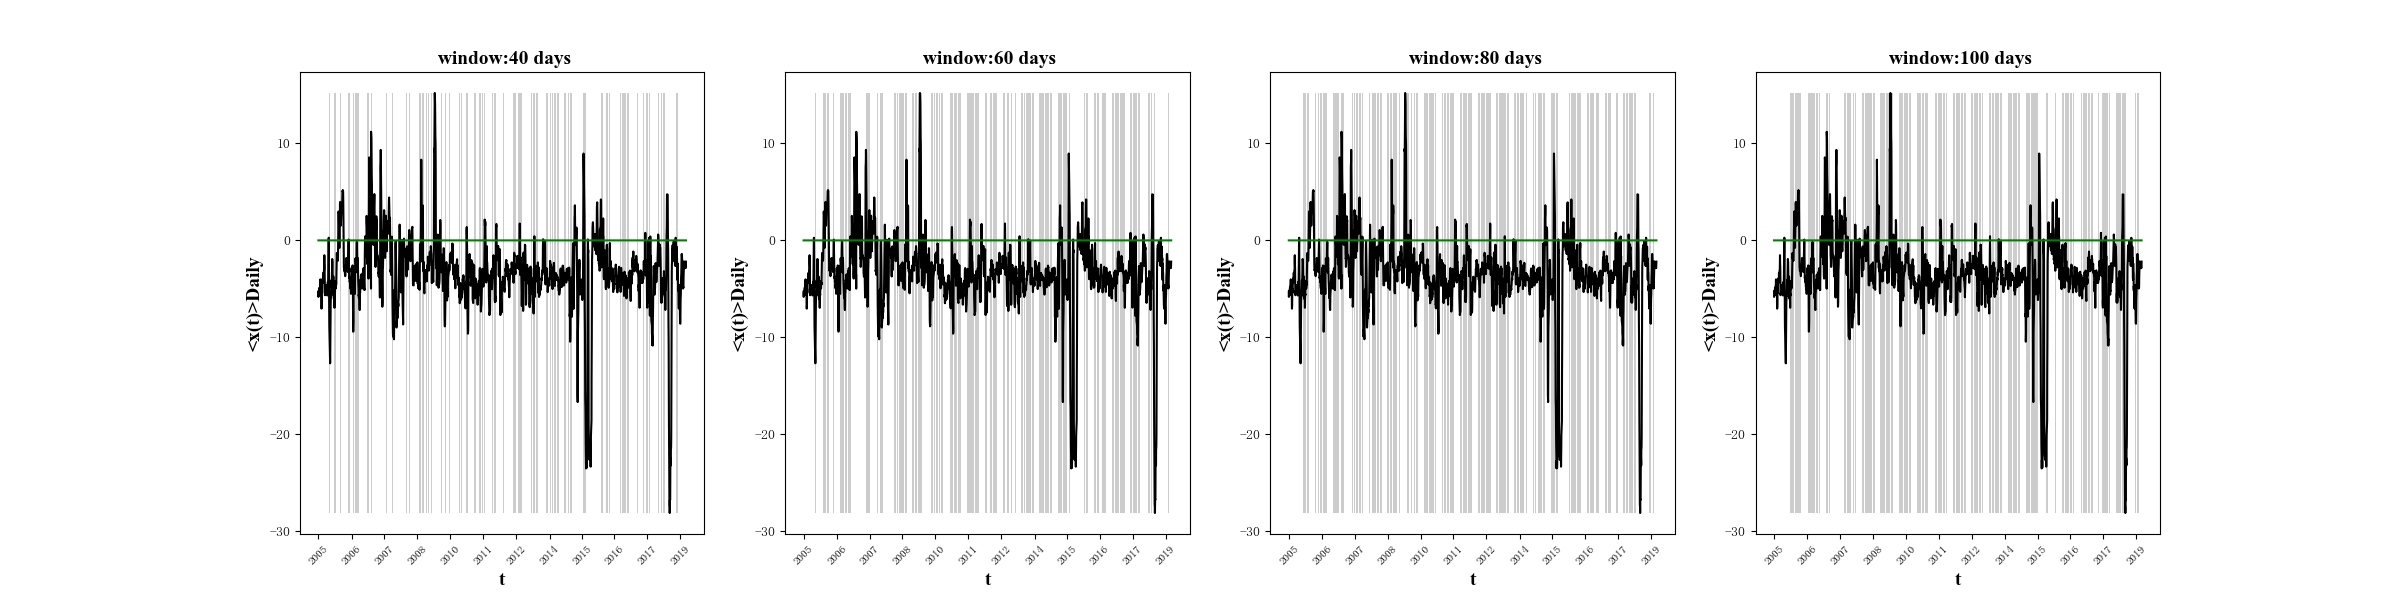

In [21]:
%matplotlib notebook
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 14,
}
fig = plt.figure(figsize=(4*6,6))

Wind =[40, 60, 80, 100]
for i in range(len(Wind)):
    plt.subplot(1,4,i+1)
    plt.plot(data3.index,df[0],c='k')
    plt.plot(data3.index, [0]*len(data3.index), c='g')
    window = Wind[i]
    plt.title(" window:%d days"%window, font1)
    res = Significant(window, X,Y,df[0])
    for j in range(len(res)):
        plt.bar(data3.index[window+50:len(X)][j],[min(df[0]),max(df[0])], alpha=0.2*(res[j]), color='k')
    plt.xlabel('t', font1)
    plt.ylabel('<x(t)>Daily',font1)
    plt.xticks(data3.index[::45*7], fontsize=8)
    plt.xticks(rotation=45)
# plt.legend(fontsize=1)

### 结果

<IPython.core.display.Javascript object>


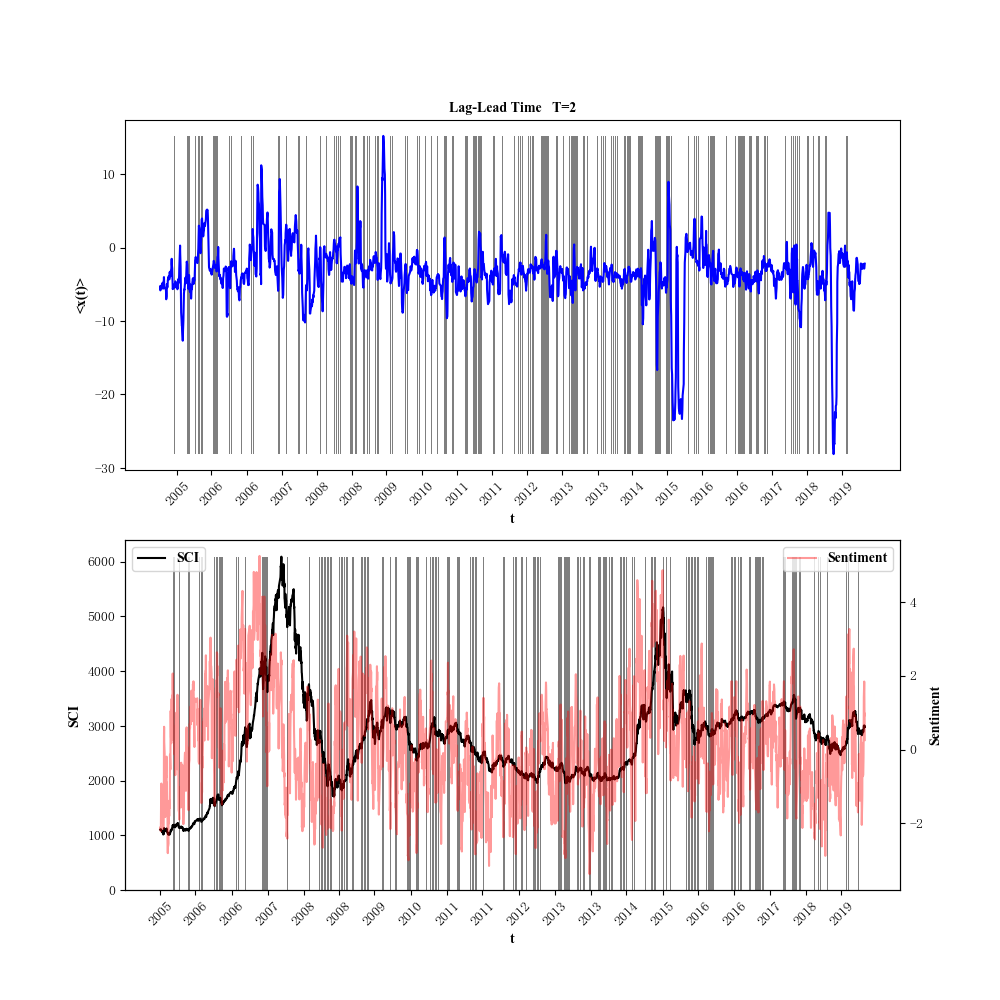

In [69]:
%matplotlib notebook
res = Significant(40, X,Y,df[0])
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 10,
}
fig = plt.figure(figsize=(10,10))
plt.subplot(211)

plt.plot(df.index,df[0],c='b')
for i in range(len(res)):
    plt.bar(data3.index[40+30:len(X)-30][i],
            [min(df[0]),max(df[0])],
            alpha=0.5*(res[i]), color='k',linewidth=2 )
#plt.plot(index,((XT1+XT2)/2)[::2],c='k', label='left+right')
#plt.plot(index,XT1[::2],c='b', label='left',marker='+')
#plt.plot(index,XT2[::2],c='r', label='right',marker='.')
plt.title("Lag-Lead Time   T=%d"%T, font1)

plt.xlabel('t', font1)
plt.ylabel('<x(t)>', font1)
#plt.xticks(df.index[::10])
plt.xticks(rotation=45)
plt.xticks(data3[80:].index[::35*5])


ax1=fig.add_subplot(212)
ax1.plot(data3.index[80:], data3[80:]['SCI'].values.reshape(-1,), color='k', label='SCI')
for i in range(len(res)):
    ax1.bar(data3.index[80:][i],
            [0,max(data3[80:]['SCI'])],
            alpha=0.5*(res[i]), color='k',linewidth=2 )
    
ax1.set_ylabel('SCI', font1)
ax1.set_xlabel('t', font1)
ax1.legend(font1)

plt.xticks(data3[80:].index)
plt.xticks(rotation=45)
plt.legend(loc=2, prop=font1)

ax2 = ax1.twinx()  # this is the important function
ax2.plot(data3[80:].index, data3[80:]['sentiment'], color='r', label='Sentiment', alpha=0.4)

ax2.legend(loc=1,prop=font1)
ax2.set_xticks(data3[80:].index[::35*5])
ax2.set_ylabel('Sentiment', font1)

plt.show()


### 数值模拟(线性)

$$
Y(i)=\left\{\begin{array}{ll}{a X(i)+\eta,} & {1 \leq i \leq 50} \\ {a X(i-2)+\eta,} & {50<i \leq 100} \\ {a X(i-5)+\eta,} & {100<i \leq 150} \\ {a X(i+3)+\eta,} & {150<i \leq 200} \\ {a X(i)+\eta,} & {200<i \leq 250}\end{array}\right.
$$

<IPython.core.display.Javascript object>


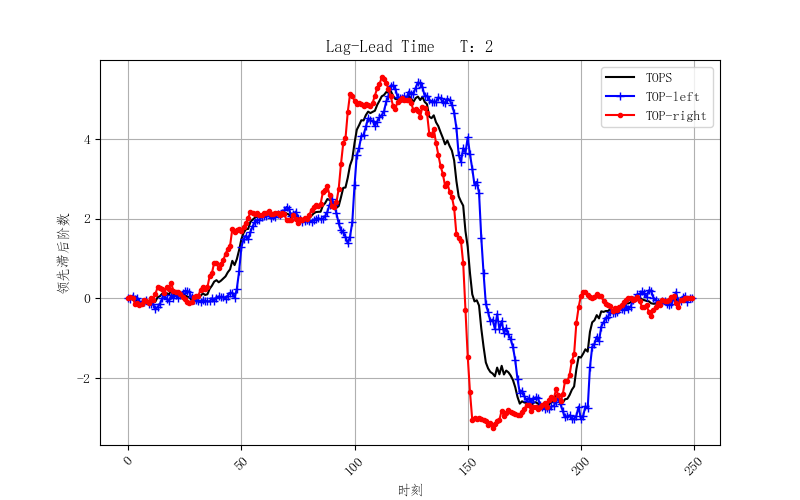

In [71]:
T = 2
N = 250
X = np.zeros(N)
X[0] = 0
for t in range(N):
    X[t] = 0.7*X[t-1] + np.random.normal(0,1)
Y =  np.zeros(N)
for t in range(N):
#     Y[t] = X[t] + np.random.normal(3,10)
    if 1<=t<50:
        Y[t] = 0.8*X[t] + np.random.normal(0,.2)
    elif 50<=t<100:
        Y[t] = 0.8*X[t-2] +  np.random.normal(0,.2)
    elif 100<=t<150:
        Y[t] = 0.8*X[t-5] +  np.random.normal(0,.2)
    elif 150<=t<200:
        Y[t] = 0.8*X[t+3] +  np.random.normal(0,.2)
    else :
        Y[t] = 0.8*X[t] + np.random.normal(0,.2)
        
X = (X - np.mean(X)) / np.std(X)
Y = (Y - np.mean(Y)) / np.std(Y)
X_t1,X_t2 = lead_lag(X,Y,T)
#X_t2 = lead_lag(X[::-1],Y[::-1],T)[::-1]
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(list(range(N)),((X_t1+X_t2)/2)[::2],c='k', label='TOPS')
plt.plot(list(range(N)),X_t1[::2],c='b', label='TOP-left',marker='+')
plt.plot(list(range(N)),X_t2[::2],c='r', label='TOP-right',marker='.')
plt.title("Lag-Lead Time   T：%d"%T)

plt.xlabel('时刻')
plt.ylabel('领先滞后阶数')
#plt.xticks(data.index[::5])
plt.xticks(rotation=45)
plt.legend()
plt.grid()